# Urban Sounds Project

### Brief Description of the Classification Problem

The classification problem addressed in this project involves urban sound data classification. The dataset used is the urbansound8k dataset, consisting of 8732 labeled sound excerpts categorized into ten classes. The objective is to develop deep learning classifiers capable of accurately identifying the class to which a given sound excerpt belongs.

# Imports

In [102]:
import pandas as pd
import numpy as np
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


# Data pre-processing and preparation

### Obtaining the data

We used the following python script:

In [103]:
# python features.py

### Unifying the class labels with the data

In [104]:
datasets = [pd.read_csv(f'datasets/urbansounds_features_{i}.csv') for i in range(1, 11)]

In [105]:
for df in datasets:
    df['Label'] = df['Label'].str.split('-').str[1].astype(int)

### Check for object values

In [106]:
for df in datasets:
    object_columns = df.select_dtypes(include=['object']).columns
    print(object_columns)

Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')
Index(['fourier_tempogram'], dtype='object')


### Convert the columns with object values to numeric

In [107]:
def calculate_mean_from_string(string):
    cleaned_string = string.replace('\n', '')
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", cleaned_string)
    array = np.array(numbers, dtype=float)
    mean_value = np.mean(array)
    return mean_value

In [108]:
for df in datasets:
    df['Label'] = df['Label'].astype('int64')

In [109]:
for df in datasets:
    df['fourier_tempogram'] = df['fourier_tempogram'].apply(calculate_mean_from_string)

### Check interval of the values per column

In [110]:
for df in datasets:
    column_intervals = df.describe().loc[['min', 'max']]
    print(column_intervals)

     chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms  \
min     0.009734    0.150077     0.126660       0.017318  0.001788   
max     0.829676    0.768014     0.285653      30.430030  0.473862   

         centroid    bandwidth   contrast      flatness       rolloff  ...  \
min     50.916749    71.255507   5.698971  6.211397e-07    106.979450  ...   
max  10907.707763  7088.299210  24.957858  9.798845e-01  18628.717306  ...   

      mcffs_32   mcffs_33   mcffs_34   mcffs_35  mcffs_36   mcffs_37  \
min -11.730761 -13.273888 -15.653493  -9.955764 -6.521128 -21.866919   
max  11.225185   9.078557  15.806270  17.319443  9.707691  17.943160   

      mcffs_38  mcffs_39   mcffs_40  Label  
min -19.719917 -8.652861  -6.523879    0.0  
max   7.872053  7.306795  16.392504    9.0  

[2 rows x 54 columns]
     chroma_stft  chroma_cqt  chroma_cens  melspectogram       rms  \
min     0.008760    0.191508     0.136980       0.056502  0.004293   
max     0.841217    0.770370     0.2853

### Check the distribution of the classes

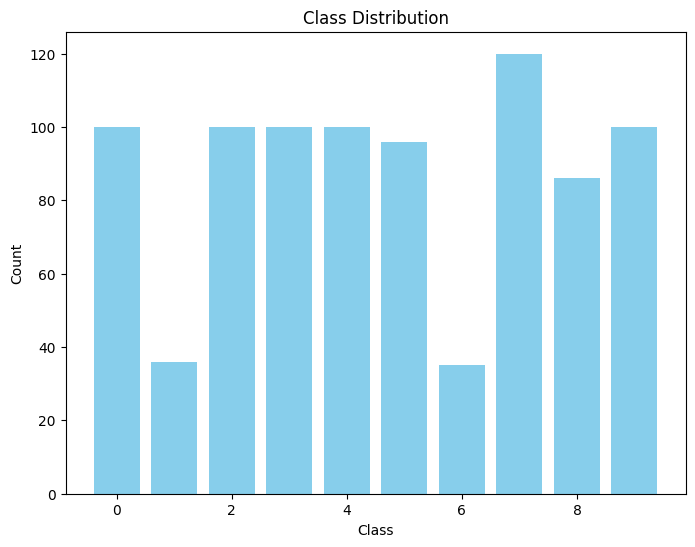

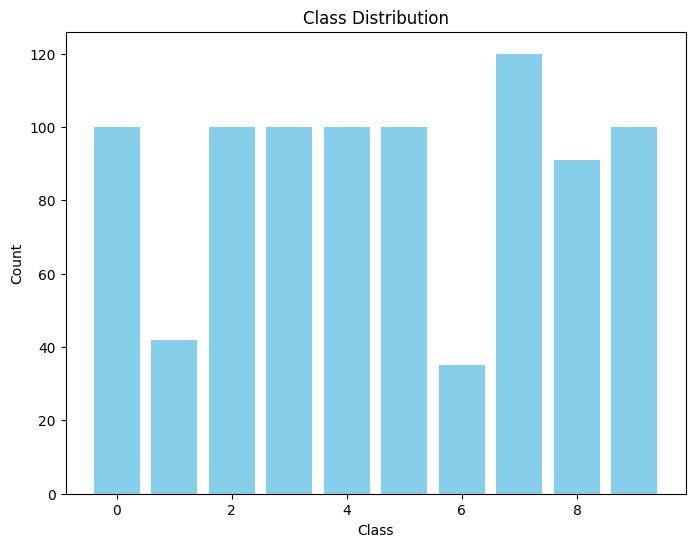

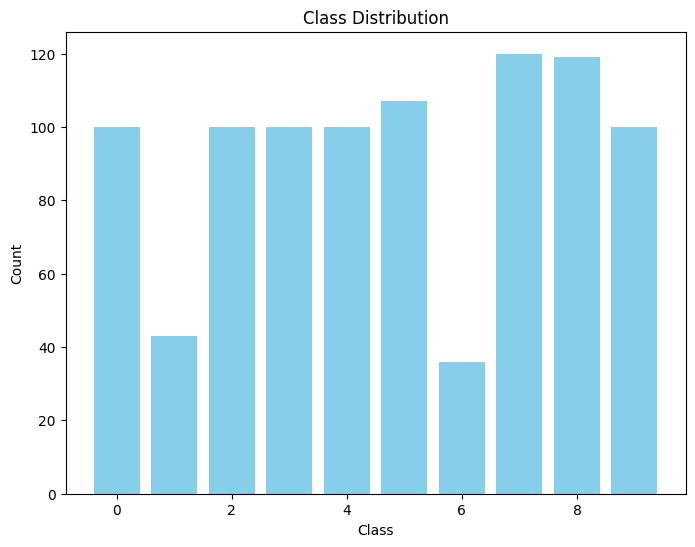

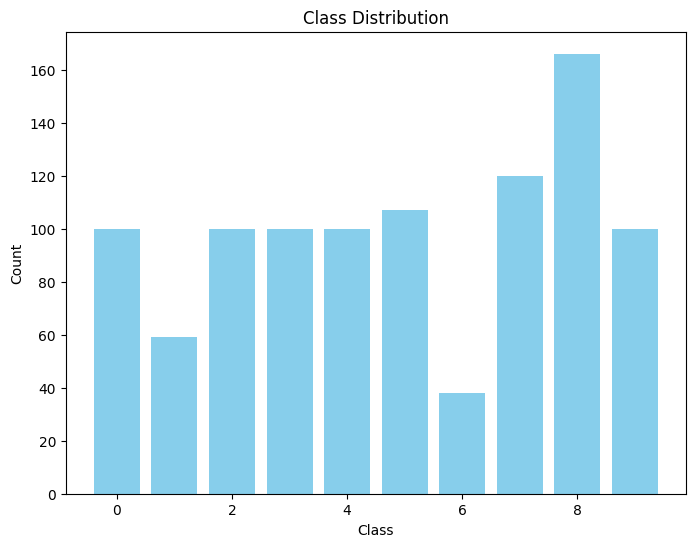

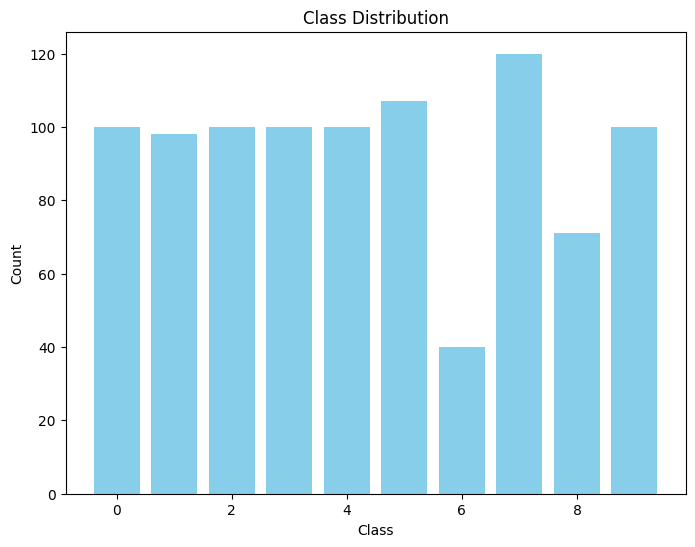

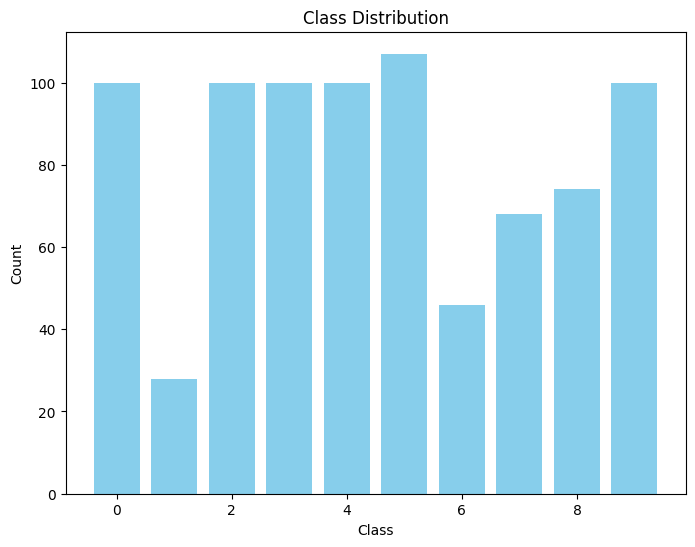

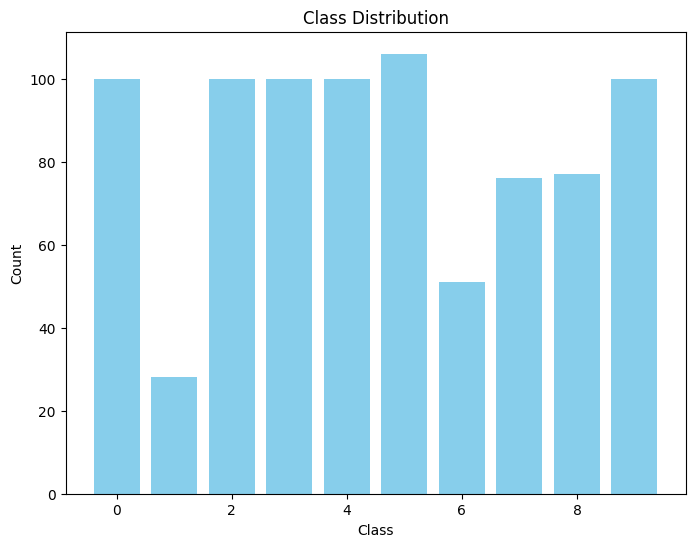

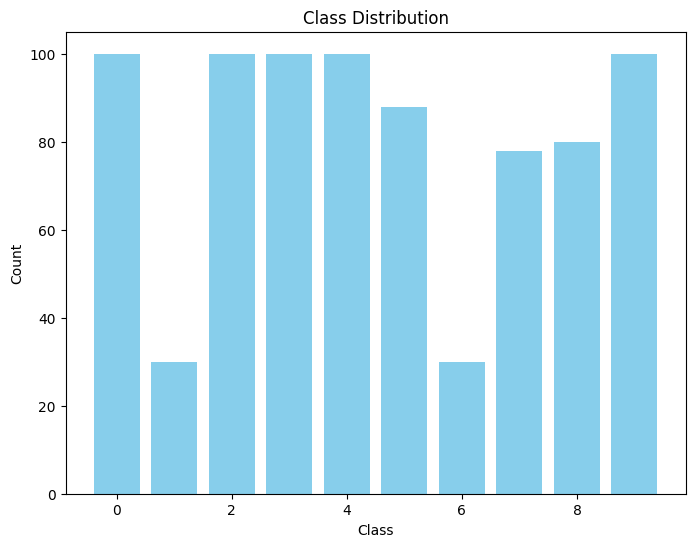

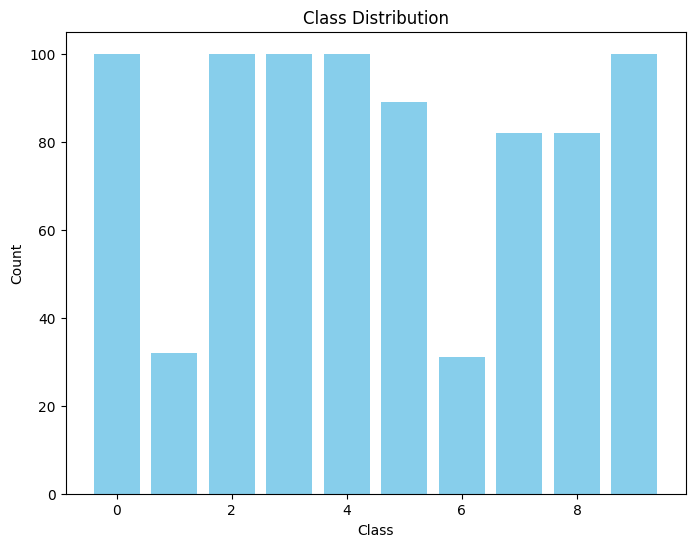

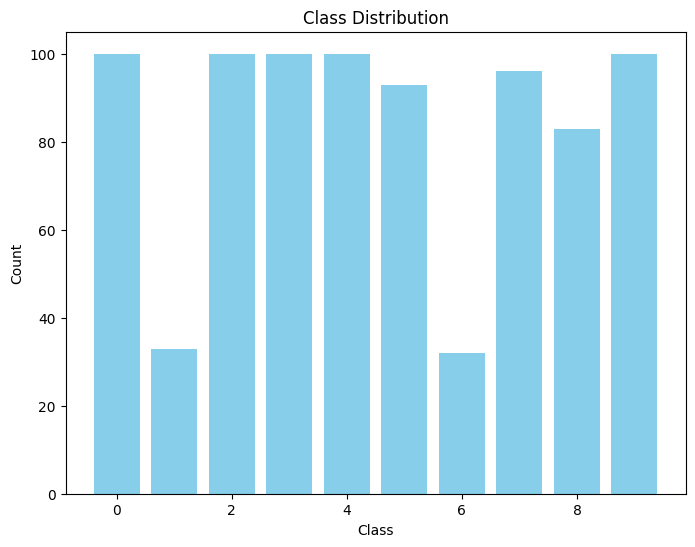

In [111]:
for df in datasets:
    class_counts = df['Label'].value_counts()
    class_labels = class_counts.index
    class_values = class_counts.values
    
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_values, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

### The classes are not balanced nor normalized, so we will need adress that in the training set

# Model architecture definition

The classifiers we chose were the following: a classifier based on multilayer perceptron (MLP) and a convolutional neural network (CNN).

### MLP classifier

For the MLP classifier, we need to define the following parameters: number of layers, number of neurons
per layer and the activation function for each layer.

# Training strategy

We used the same training strategy for both models.

In order to define the details for the training strategies, we ran a grid search over some hyperparameters.
Choosing the best optimizer involves expererimenting and comparing the results of different optimizers to see what works best. We tested the following: SGD, Adam, and Adagrad.

To determine a good learning rate value, we tested some between the tradicional interval of 0.1 to 0.01.

Some common batch sizes of number of samples used in each iteration are 32, 64, 128 and we ended up testing all these values.

Too few epochs may result in underfitting, while too many epochs may lead to overfitting, so we tried 300 and got good results.

For early stopping, we tested patience levels of 3 and 6 and kept the rest of the parameters as default and for dropout rate we some in the range of 0 to 1.

L1_L2 regularization was the technique choosen by us for weigth regularization and we tested some values between 0 and 0.1.

For now we did not use any data augmentaion techniques neither transfer learning. 

After running the grid search, we found the best values for the parameters and proceeded to use them in the neural networks.

# Performance evaluation

In [112]:
learning_rate = '0.1'

In [113]:
# Combine all labels from different datasets
all_labels = np.concatenate([df['Label'].values for df in datasets])

# Define the stratified k-fold
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [114]:
# Hyperparameter Grid
dropout_values = np.arange(0, 1, 0.01)
patience_values = [3, 6]
optimizers = ['adam', 'sgd', 'adagrad']
regulizers_value = np.arange(0, 0.1, 0.01)
batch_sizes = [32, 64, 128]

In [115]:
def grid_search_best_parameters():
    # Best results tracker
    best_result = {
        'dropout': None,
        'patience': None,
        'optimizer': None,
        'regulaizer': None,
        'batch_size': None,
        'average_accuracy': 0
    }
    
    total_iterations = len(dropout_values) * len(regulizers_value) * len(optimizers) * len(patience_values) * len(batch_sizes)
    
    with tqdm(total=total_iterations, desc="Grid Search Progress") as pbar:
        # Grid Search Loop
        for dropout in dropout_values:
            for regulizer in regulizers_value:
                for optimizer in optimizers:
                    for patience in patience_values:
                        for batch_size in batch_sizes:
                            cv_scores = []
    
                            for fold, (train_index, val_index) in enumerate(stratified_kfold.split(range(len(all_labels)), all_labels)):
                                # Use the current fold as the validation set
                                validation_dataset = datasets[fold]
    
                                # Combine the remaining datasets as the training set
                                training_datasets = [dataset for index, dataset in enumerate(datasets) if index != fold]
                                combined_df = pd.concat(training_datasets, ignore_index=True)
    
                                # Classification
                                X_train = combined_df.drop('Label', axis=1)
                                y_train = combined_df['Label']
    
                                # Oversample the features values using SMOTE
                                smote = SMOTE(random_state=42)
                                X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
                                # Standardize the feature values
                                scaler = StandardScaler()
                                X_train_scaled = scaler.fit_transform(X_resampled)
    
                                # Classification for validation set
                                X_val = validation_dataset.drop('Label', axis=1)
                                y_val = validation_dataset['Label']
    
                                # Oversample the features values using SMOTE for validation set
                                X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
                                X_val_scaled = scaler.transform(X_val_resampled)
    
                                mean_neurons = (X_train_scaled.shape[1] + len(np.unique(y_resampled))) // 2
                                num_input_neurons = X_train_scaled.shape[1]
                                num_output_neurons = len(np.unique(y_resampled))
                                neurons_hidden_layer = int(2 / 3 * num_input_neurons + 1 / 3 * num_output_neurons)
    
                                # Define and compile the model with hyperparameters
                                model = tf.keras.Sequential([
                                    tf.keras.layers.Dense(units=neurons_hidden_layer, activation='relu',
                                                          input_shape=(X_train_scaled.shape[1],),
                                                          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regulizer, l2=regulizer)),
                                    tf.keras.layers.Dropout(dropout),
                                    tf.keras.layers.Dense(units=mean_neurons, activation='relu'),
                                    tf.keras.layers.Dropout(dropout),
                                    tf.keras.layers.Dense(units=len(np.unique(y_resampled)), activation='softmax')
                                ])
                                model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    
    
                                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
                                # Train the model
                                model.fit(X_train_scaled, y_resampled, validation_data=(X_val_scaled, y_val_resampled),
                                          batch_size=batch_size, callbacks=[early_stopping])
    
                                # Evaluate the model on the validation set
                                y_val_pred_probs = model.predict(X_val_scaled)
                                y_val_pred = np.argmax(y_val_pred_probs, axis=1)
    
                                # Calculate and store accuracy for this fold
                                fold_accuracy = accuracy_score(y_val_resampled, y_val_pred)
                                cv_scores.append(fold_accuracy)
    
                                # Update progress bar
                                pbar.update(1)
    
                            # Calculate and store the average accuracy for these hyperparameters
                            overall_average_accuracy = np.mean(cv_scores)
    
                            # Check if the current set of hyperparameters is better than the best
                            if overall_average_accuracy > best_result['average_accuracy']:
                                best_result = {
                                    'dropout': dropout,
                                    'patience': patience,
                                    'optimizer': optimizer,
                                    'regulizer': regulizer,
                                    'batch_size': batch_size,
                                    'average_accuracy': overall_average_accuracy
                                }

In [116]:
best_result = grid_search_best_parameters()
dropout = best_result['dropout']
patience = best_result['patience']
optimizer = best_result['optimizer']
regulizer = best_result['regulizer']
batch_size = best_result['batch_size']

Grid Search Progress:   0%|          | 0/18000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
266/283 [===========================>..] - ETA: 0s - loss: 1.6602WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3392F6A0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 1/18000 [00:03<18:15:43,  3.65s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
264/282 [===========================>..] - ETA: 0s - loss: 1.6758WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2C645120> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 2/18000 [00:08<23:02:10,  4.61s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
274/282 [============================>.] - ETA: 0s - loss: 1.6304WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA349F3A60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 3/18000 [00:11<17:20:31,  3.47s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
262/282 [==========================>...] - ETA: 0s - loss: 1.5797WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3009C7C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 4/18000 [00:13<14:38:52,  2.93s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
260/282 [==========================>...] - ETA: 0s - loss: 1.6210WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA32C4ACA0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 5/18000 [00:15<13:04:28,  2.62s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
273/292 [===========================>..] - ETA: 0s - loss: 1.6046WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2F462840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 6/18000 [00:17<12:11:23,  2.44s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
286/289 [============================>.] - ETA: 0s - loss: 1.5622WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA321D4EA0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 7/18000 [00:19<11:45:59,  2.35s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
267/289 [==========================>...] - ETA: 0s - loss: 1.6528WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3313B420> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 8/18000 [00:21<11:18:31,  2.26s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
271/287 [===========================>..] - ETA: 0s - loss: 1.6608WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA33023920> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 9/18000 [00:23<10:53:05,  2.18s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
270/284 [===========================>..] - ETA: 0s - loss: 1.7122WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA372BAC00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 10/18000 [00:25<10:39:54,  2.13s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
129/142 [==========================>...] - ETA: 0s - loss: 1.8384WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3AA43E20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 11/18000 [00:27<10:11:18,  2.04s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
132/141 [===========================>..] - ETA: 0s - loss: 1.9008WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3ACEBEC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 12/18000 [00:29<9:47:19,  1.96s/it] 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/141 [=========================>....] - ETA: 0s - loss: 1.9259WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2C4AECA0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 13/18000 [00:31<10:10:32,  2.04s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/141 [=========================>....] - ETA: 0s - loss: 1.9073WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2FB42AC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 14/18000 [00:33<9:49:42,  1.97s/it] 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
128/141 [==========================>...] - ETA: 0s - loss: 1.8788WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2C40E980> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 15/18000 [00:34<9:29:58,  1.90s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
122/146 [========================>.....] - ETA: 0s - loss: 1.9248WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA32307C40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 16/18000 [00:36<9:18:03,  1.86s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
126/145 [=========================>....] - ETA: 0s - loss: 1.8493WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA32F7E520> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 17/18000 [00:38<9:26:12,  1.89s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
132/145 [==========================>...] - ETA: 0s - loss: 1.8935WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3222F420> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 18/18000 [00:40<9:16:50,  1.86s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
117/144 [=======================>......] - ETA: 0s - loss: 1.9025WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA33047F60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 19/18000 [00:42<9:08:42,  1.83s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
131/142 [==========================>...] - ETA: 0s - loss: 1.8573WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3AD039C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 20/18000 [00:43<9:03:51,  1.81s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/71 [===================>..........] - ETA: 0s - loss: 2.1181WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA37236FC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 21/18000 [00:45<8:49:27,  1.77s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
48/71 [===================>..........] - ETA: 0s - loss: 2.2561WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA36F06980> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 22/18000 [00:47<8:36:32,  1.72s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
48/71 [===================>..........] - ETA: 0s - loss: 2.2188WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3C667E20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 23/18000 [00:48<8:26:26,  1.69s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
48/71 [===================>..........] - ETA: 0s - loss: 2.2076WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA34A5F600> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 24/18000 [00:50<9:01:24,  1.81s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/71 [===================>..........] - ETA: 0s - loss: 2.1933WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA30566160> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 25/18000 [00:52<8:42:40,  1.74s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/73 [===================>..........] - ETA: 0s - loss: 2.0466WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA31F5CF40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 26/18000 [00:54<8:31:55,  1.71s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
72/73 [============================>.] - ETA: 0s - loss: 2.0013WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2C4AD1C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 27/18000 [00:55<8:24:31,  1.68s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/73 [===================>..........] - ETA: 0s - loss: 2.1915WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA32FAB6A0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 28/18000 [00:57<8:14:43,  1.65s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/72 [===========================>..] - ETA: 0s - loss: 2.1213WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3AD63240> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 29/18000 [00:59<8:17:06,  1.66s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
51/71 [====================>.........] - ETA: 0s - loss: 2.1478WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3AAA7560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 30/18000 [01:00<8:32:07,  1.71s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
270/283 [===========================>..] - ETA: 0s - loss: 1.6460WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA371C91C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 31/18000 [01:03<9:32:15,  1.91s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
261/282 [==========================>...] - ETA: 0s - loss: 1.5985WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3C19BCE0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 32/18000 [01:05<10:43:37,  2.15s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
260/282 [==========================>...] - ETA: 0s - loss: 1.6609WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3ECC3BA0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 33/18000 [01:08<11:13:13,  2.25s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
257/282 [==========================>...] - ETA: 0s - loss: 1.7226WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA39602B60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 34/18000 [01:11<11:55:33,  2.39s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
282/282 [==============================] - ETA: 0s - loss: 1.6430WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2C4EB4C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 35/18000 [01:13<11:40:46,  2.34s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
270/292 [==========================>...] - ETA: 0s - loss: 1.6209WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA323922A0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 36/18000 [01:15<11:37:39,  2.33s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
277/289 [===========================>..] - ETA: 0s - loss: 1.6376WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2C4AF600> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 37/18000 [01:18<11:50:25,  2.37s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
286/289 [============================>.] - ETA: 0s - loss: 1.6217WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA32303380> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 38/18000 [01:21<12:31:38,  2.51s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
279/287 [============================>.] - ETA: 0s - loss: 1.6151WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3AA7AE80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 39/18000 [01:23<12:32:33,  2.51s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
271/284 [===========================>..] - ETA: 0s - loss: 1.6614WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3C06FE20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 40/18000 [01:25<12:07:47,  2.43s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
131/142 [==========================>...] - ETA: 0s - loss: 1.8874WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA373D7600> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 41/18000 [01:27<11:20:51,  2.27s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
128/141 [==========================>...] - ETA: 0s - loss: 1.8163WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3F423420> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 42/18000 [01:29<10:40:08,  2.14s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
129/141 [==========================>...] - ETA: 0s - loss: 1.8808WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3F872340> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 43/18000 [01:31<10:18:50,  2.07s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
134/141 [===========================>..] - ETA: 0s - loss: 1.8392WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3FBAAAC0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 44/18000 [01:33<10:07:06,  2.03s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
140/141 [============================>.] - ETA: 0s - loss: 1.8373WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA444EF2E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 45/18000 [01:35<10:18:10,  2.07s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
128/146 [=========================>....] - ETA: 0s - loss: 1.8297WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3075B600> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 46/18000 [01:37<10:49:27,  2.17s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
119/145 [=======================>......] - ETA: 0s - loss: 1.9237WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3354AE80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 47/18000 [01:39<10:19:52,  2.07s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
122/145 [========================>.....] - ETA: 0s - loss: 1.9073WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA324251C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 48/18000 [01:41<10:30:34,  2.11s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
123/144 [========================>.....] - ETA: 0s - loss: 1.9334WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2FC5D940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 49/18000 [01:43<10:21:42,  2.08s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
126/142 [=========================>....] - ETA: 0s - loss: 1.8344WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2E66E2A0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 50/18000 [01:45<10:10:25,  2.04s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
51/71 [====================>.........] - ETA: 0s - loss: 1.9441WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3C9ED800> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 51/18000 [01:47<9:54:06,  1.99s/it] 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/71 [====================>.........] - ETA: 0s - loss: 2.1838WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3F0F34C0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 52/18000 [01:49<9:28:49,  1.90s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/71 [===================>..........] - ETA: 0s - loss: 2.0703WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3FC477E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 53/18000 [01:51<9:02:15,  1.81s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/71 [=====================>........] - ETA: 0s - loss: 2.0888WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3F60B560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 54/18000 [01:52<8:49:49,  1.77s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
71/71 [==============================] - ETA: 0s - loss: 1.9888WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA42CAF7E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 55/18000 [01:54<8:42:42,  1.75s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/73 [===================>..........] - ETA: 0s - loss: 2.1757WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA45CD6E80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 56/18000 [01:56<8:33:03,  1.72s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
70/73 [===========================>..] - ETA: 0s - loss: 2.0743WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA45B6E700> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 57/18000 [01:57<8:27:40,  1.70s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/73 [===================>..........] - ETA: 0s - loss: 2.1120WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA495F37E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 58/18000 [01:59<9:10:23,  1.84s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/72 [==================>...........] - ETA: 0s - loss: 2.1442WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3F5145E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 59/18000 [02:01<8:49:42,  1.77s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/71 [===================>..........] - ETA: 0s - loss: 2.1777WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3AFAD8A0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux,

Grid Search Progress:   0%|          | 60/18000 [02:03<8:37:19,  1.73s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
270/283 [===========================>..] - ETA: 0s - loss: 2.1258WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2ED3B740> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 61/18000 [02:04<8:44:51,  1.76s/it]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
266/282 [===========================>..] - ETA: 0s - loss: 2.1128WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3AED27A0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linu

Grid Search Progress:   0%|          | 61/18000 [02:06<10:21:03,  2.08s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\alexa\anaconda3\envs\AC2\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 427, in converted_call
    converted_f = _convert_actual(target_entity, program_ctx)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alexa\anaconda3\envs\AC2\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 269, in _convert_actual
    transformed, module, source_map = _TRANSPILER.transform(entity, program_ctx)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alexa\anaconda3\envs\AC2\Lib\site-packages\tensorflow\python\autograph\pyct\transpiler.py", line 282, in transform
    return self.transform_function(obj, user_context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\alexa\anaconda3\envs\AC2\Lib\site-packages\tensorflow\python\autograph\pyct\transpiler.py", line 490, in transform_function
    transformed_fn = factory.instanti

In [117]:
best_result_strint = f"Best Hyperparameters and Accuracy:\n" \
                     f"dropout: {dropout}\n" \
                     f"patience: {patience}\n" \
                     f"optimizer: {optimizer}\n" \
                     f"regulizer: {regulizer}\n" \
                     f"batch_size: {batch_size}\n" \
                     f"average_accuracy: {best_result['average_accuracy']}\n"

print(best_result_strint)

NameError: name 'best_result' is not defined

Now lets test for the best epochs

In [118]:
def find_best_epochs():
    epochs_range=(150, 350)
    accuracy_threshold=0.1

    cv_scores = []

    for num_epochs in range(epochs_range[0], epochs_range[1] + 1):
        print(f"Testing with {num_epochs} epochs...")

        for fold, (train_index, val_index) in enumerate(stratified_kfold.split(range(len(all_labels)), all_labels)):
            # Use the current fold as the validation set
            validation_dataset = datasets[fold]

            # Combine the remaining datasets as the training set
            training_datasets = [dataset for index, dataset in enumerate(datasets) if index != fold]
            combined_df = pd.concat(training_datasets, ignore_index=True)

            # Classification
            X_train = combined_df.drop('Label', axis=1)
            y_train = combined_df['Label']

            # Oversample the features values using SMOTE
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

            # Standardize the feature values
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_resampled)

            # Classification for validation set
            X_val = validation_dataset.drop('Label', axis=1)
            y_val = validation_dataset['Label']

            # Oversample the features values using SMOTE for validation set
            X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
            X_val_scaled = scaler.transform(X_val_resampled)

            mean_neurons = (X_train_scaled.shape[1] + len(np.unique(y_resampled))) // 2
            num_input_neurons = X_train_scaled.shape[1]
            num_output_neurons = len(np.unique(y_resampled))
            neurons_hidden_layer = int(2 / 3 * num_input_neurons + 1 / 3 * num_output_neurons)

            # Define and compile the model with hyperparameters
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(units=neurons_hidden_layer, activation='relu',
                                      input_shape=(X_train_scaled.shape[1],),
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regulizer, l2=regulizer)),
                tf.keras.layers.Dropout(dropout),
                tf.keras.layers.Dense(units=mean_neurons, activation='relu'),
                tf.keras.layers.Dropout(dropout),
                tf.keras.layers.Dense(units=len(np.unique(y_resampled)), activation='softmax')
            ])
            model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

            # Train the model
            model.fit(X_train_scaled, y_resampled, validation_data=(X_val_scaled, y_val_resampled),
                      batch_size=batch_size, epochs=num_epochs, callbacks=[early_stopping])

            # Evaluate the model on the validation set
            y_val_pred_probs = model.predict(X_val_scaled)
            y_val_pred = np.argmax(y_val_pred_probs, axis=1)

            # Calculate and store accuracy for this fold
            fold_accuracy = accuracy_score(y_val_resampled, y_val_pred)
            cv_scores.append(fold_accuracy)

        # Calculate and store the average accuracy for these hyperparameters
        overall_average_accuracy = np.mean(cv_scores)

        # Check if accuracy improvement is below the threshold
        if num_epochs > epochs_range[0] and overall_average_accuracy - cv_scores[-5] < accuracy_threshold:
            print(f"Stopped testing at {num_epochs} epochs.")
            return num_epochs

    print("Maximum number of epochs tested. Consider increasing the range.")
    return epochs_range[1]


In [119]:
best_epochs = find_best_epochs()
print(f"The best number of epochs is: {best_epochs}")

Testing with 150 epochs...
Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
276/283 [============================>.] - ETA: 0s - loss: 4.2335WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA2C4AD4E0> and will run it as-is.
Please report this to the TensorFlow team. When filing th

KeyboardInterrupt: 

Now lets train the model with the best parameters

In [120]:
cv_scores = []

for fold, (train_index, val_index) in enumerate(stratified_kfold.split(range(len(all_labels)), all_labels)):
    # Use the current fold as the validation set
    validation_dataset = datasets[fold]

    # Combine the remaining datasets as the training set
    training_datasets = [dataset for index, dataset in enumerate(datasets) if index != fold]
    combined_df = pd.concat(training_datasets, ignore_index=True)

    # Classification
    X_train = combined_df.drop('Label', axis=1)
    y_train = combined_df['Label']

    # Oversample the features values using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Standardize the feature values
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)

    # Classification for validation set
    X_val = validation_dataset.drop('Label', axis=1)
    y_val = validation_dataset['Label']

    # Oversample the features values using SMOTE for validation set
    X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
    X_val_scaled = scaler.transform(X_val_resampled)

    mean_neurons = (X_train_scaled.shape[1] + len(np.unique(y_resampled))) // 2
    num_input_neurons = X_train_scaled.shape[1]
    num_output_neurons = len(np.unique(y_resampled))
    neurons_hidden_layer = int(2 / 3 * num_input_neurons + 1 / 3 * num_output_neurons)

    # Define and compile the model with hyperparameters
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=neurons_hidden_layer, activation='relu',
                              input_shape=(X_train_scaled.shape[1],),
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regulizer, l2=regulizer)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=mean_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=len(np.unique(y_resampled)), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    # Train the model
    model.fit(X_train_scaled, y_resampled, validation_data=(X_val_scaled, y_val_resampled),
              batch_size=batch_size,epochs=best_epochs, callbacks=[early_stopping])

    # Evaluate the model on the validation set
    y_val_pred_probs = model.predict(X_val_scaled)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)

    # Calculate and store accuracy for this fold
    fold_accuracy = accuracy_score(y_val_resampled, y_val_pred)
    cv_scores.append(fold_accuracy)

# Calculate and store the average accuracy for these hyperparameters
overall_average_accuracy = np.mean(cv_scores)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
264/283 [==========================>...] - ETA: 0s - loss: 4.1402WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001AA3EA58680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 


KeyboardInterrupt



## CNN classifier

In [146]:
# Define hyperparameters
regulizer = 0.01  # Example regularization strength
dropout = 0.5  # Example dropout rate
optimizer = 'adam'  # Example optimizer
batch_size = 32  # Example batch size
best_epochs = 50  # Example number of epochs
patience = 5  # Example patience for early stopping
mean_neurons = 31  # Example mean_neurons

cv_scores = []

for fold, (train_index, val_index) in enumerate(stratified_kfold.split(range(len(all_labels)), all_labels)):
    # Use the current fold as the validation set
    validation_dataset = datasets[fold]

    # Combine the remaining datasets as the training set
    training_datasets = [dataset for index, dataset in enumerate(datasets) if index != fold]
    combined_df = pd.concat(training_datasets, ignore_index=True)

    # Keep only columns representing MFCCs
    mcff = combined_df[13:]
    mfcc_columns = mcff.columns
    X_train = combined_df[mfcc_columns]
    y_train = combined_df['Label']

    # Oversample the features values using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Standardize the feature values
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)

    # Classification for validation set
    X_val = validation_dataset[mfcc_columns]
    y_val = validation_dataset['Label']

    # Oversample the features values using SMOTE for validation set
    X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
    X_val_scaled = scaler.transform(X_val_resampled)

   # Assuming X_train_scaled and X_val_scaled are 2D with shape (None, 54, 1)

    print(X_val_scaled.shape)
    # Reshape data for 2D CNN (assuming X_train_scaled is 2D)
    X_train_scaled = X_train_scaled.reshape(1200, 54, 1)

    X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], 940, 54, 1)
    neurons_hidden_layer = int(2 / 3 * (X_train_scaled.shape[1] + len(np.unique(y_resampled))))

    # Define and compile the CNN model with hyperparameters
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                               input_shape=(940,54,1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=neurons_hidden_layer, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regulizer, l2=regulizer)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=mean_neurons, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(units=len(np.unique(y_resampled)), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

    # Train the CNN model
    model.fit(X_train_scaled, y_resampled, validation_data=(X_val_scaled, y_val_resampled),
              batch_size=batch_size, epochs=best_epochs, callbacks=[early_stopping])

    # Evaluate the CNN model on the validation set
    y_val_pred_probs = model.predict(X_val_scaled)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)

    # Calculate and store accuracy for this fold
    fold_accuracy = accuracy_score(y_val_resampled, y_val_pred)
    cv_scores.append(fold_accuracy)

# Calculate and store the average accuracy for these hyperparameters
overall_average_accuracy = np.mean(cv_scores)


(1200, 54)


ValueError: cannot reshape array of size 488160 into shape (1200,54,1)